<a href="https://colab.research.google.com/github/SagarMeti5/churn_prediction/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

In [5]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
print(df.shape)
df.info()
df.describe(include='all').T
df['Churn'].value_counts(normalize=True)  # check balance
df.isnull().sum()

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [7]:
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)


if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip().replace('', np.nan))
    df['TotalCharges'] = df['TotalCharges'].fillna(0)  # or use median


binary_cols = [c for c in df.columns if df[c].nunique()==2 and set(df[c].dropna().unique())<=set(['Yes','No'])]
for c in binary_cols:
    df[c] = df[c].map({'Yes':1,'No':0})

if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [8]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.shape

(7043, 31)

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [10]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC: 0.8417577307602884


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC: 0.8242566328244078


Text(0.5, 1.0, 'Top 10 features')

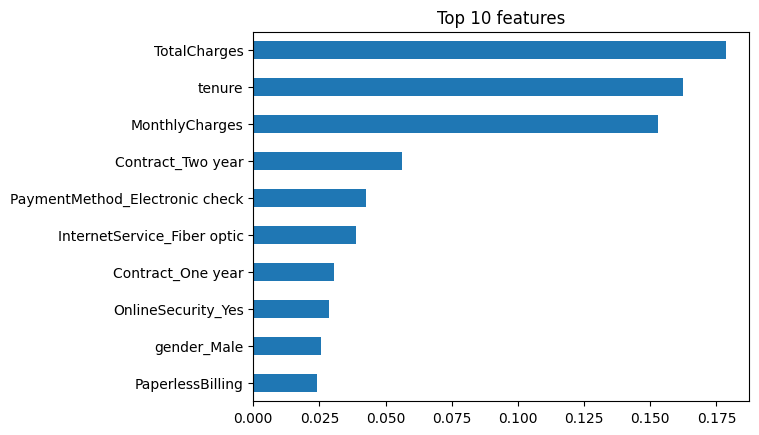

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
feat_imp.plot(kind='barh'); plt.gca().invert_yaxis(); plt.title("Top 10 features")

Text(0.5, 1.0, 'ROC Curve')

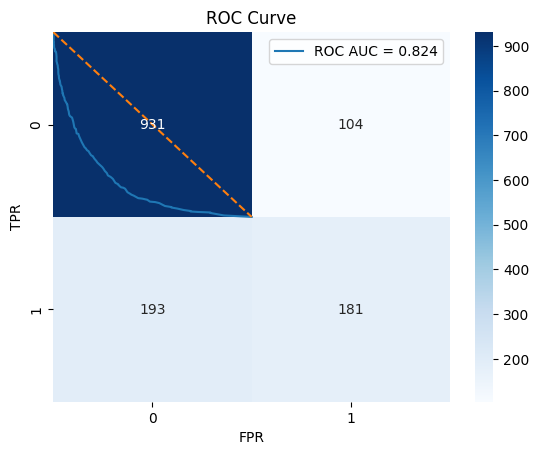

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Predicted'); plt.ylabel('Actual')

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title("ROC Curve")

In [13]:
joblib.dump(rf, 'rf_churn_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']